# Polarimetric SAR IMage Analysis

## Introduction
The Docker container __mort/sardocker__  provides easy access to Python scripts for analysis of polarimetric synthetic aperture radar (polSAR) imagery. These scripts are described in <a href="http://www.amazon.com/Analysis-Classification-Change-Detection-Sensing/dp/1466570377/ref=dp_ob_title_bk">Canty(2014), Image analysis, Classification and Change Detection in Remote Sensing, 3rd Revised Ed.</a> In addition to scripts for polSAR speckle filtering, ENL estiation and change detection, the container encapsulates the command line interface of the <a href="https://www.asf.alaska.edu/data-tools/mapready/ ">ASF MapReady</a> software for terrain correction and geocoding of SAR images. The user interacts with the software in an IPython notebook served from within the Docker container.

## Software Installation
 1. <a href="https://docs.docker.com/installation/">Install Docker</a>
 2. In a terminal, run the command<br />
      __sudo docker run -d -p 433:8888 --name=sar -v *your_image_directory*:/home/imagery mort/sardocker__<br />
     where *your_image_directory* is the path to your SAR data. 
 3. Point your browser to<br /> 
    __localhost:433__
 4. Click on this tutorial, or open a new notebook with __New/Python 2__.

Here is a listing of the main directory __/home__ in the container. It contains the various Python and bash scripts required for preprocessing and change detection:

In [1]:
!ls -l /home

total 9824
-rw-rw-r-- 1 root root   10931 Dec  4 09:42 dispms.py
-rw-rw-r-- 1 root root    7749 Oct 18 14:21 enlml.py
-rw-rw-r-- 1 root root    9318 Nov 20 09:45 gamma_filter.py
drwxr-xr-x 6 root root    4096 Dec 10 13:13 imagery
-rw-rw-r-- 1 root root    4408 Oct 18 14:21 ingest.py
-rwxr-xr-x 1 root root    8072 Dec 10 11:42 libprov_means.so
-rwxrw-r-- 1 root root    2926 Dec 10 13:36 mapready.sh
-rw-rw-r-- 1 root root    9781 Nov 25 14:53 omnibus.py
-rwxrw-r-- 1 root root    1188 Dec 10 13:36 omnibus.sh
-rwxrw-r-- 1 root root    1047 Dec 10 13:25 omnibus_s1.sh
-rw-rw-r-- 1 root root     693 Oct 18 14:21 prov_means.c
-rw-rw-r-- 1 root root     841 Oct 18 14:21 radarsat2quadpol.template
-rw-rw-r-- 1 root root    8680 Nov 20 13:16 register.py
-rw-rw-r-- 1 root root     828 Oct 18 14:21 terrahomexdualpol.template
-rw-r----- 1 root root 4949220 Dec  9 08:40 tutorial.ipynb
-rw-r--r-- 1 root root 4981502 Dec 10 13:37 tutorialnew.ipynb
-rw-rw-r-- 1 root root      50 Oct 18 14:21 utm.prj
-rw-

The __/home/imagery__ directory contains the polametric SAR data and is shared with the host. In the present example there are 12 Radarsat-2 quadpol images in SLC (single-look complex) format along with a dem (digital elevation model). Acquistion times range from May 25, 2009 (20090525) to October 11, 2010 (20101011):

In [2]:
!ls -l /home/imagery | grep "_SLC$"

drwx------ 4 root root    4096 Oct 11 15:25 RS2_OK5491_PK71074_DK68879_FQ21_20100426_172459_HH_VV_HV_VH_SLC
drwx------ 4 root root    4096 Oct 11 13:16 RS2_OK5491_PK71074_DK68879_FQ21_20100520_172458_HH_VV_HV_VH_SLC
drwx------ 4 root root    4096 Oct 11 14:11 RS2_OK5491_PK71074_DK68879_FQ21_20100707_172459_HH_VV_HV_VH_SLC


The images are level one SLC (single look complex format). For example, below are the contents of the image directory corresponding to acquistion date 20100426 (April 26, 2010). The four polarization combinations HH, HV,VH and VV are are stored as complex numbers in GeoTiff format:

In [3]:
ls -l /home/imagery/RS2_OK5491_PK71074_DK68879_FQ21_20100426_172459_HH_VV_HV_VH_SLC

total 336276
-rw------- 1 root root   741610 Apr 27  2010 BrowseImage.tif
-rw------- 1 root root    44218 Oct  2  2009 DFAIT_RS2 EULA_Single User License.pdf
-rw------- 1 root root      623 Jun 15 16:12 GEARTH_POLY.kml
-rw------- 1 root root    89600 Apr 28  2010 Thumbs.db
-rw------- 1 root root 85731468 Apr 27  2010 imagery_HH.tif
-rw------- 1 root root 85731468 Apr 27  2010 imagery_HV.tif
-rw------- 1 root root 85731468 Apr 27  2010 imagery_VH.tif
-rw------- 1 root root 85731468 Apr 27  2010 imagery_VV.tif
-rw------- 1 root root    49475 Apr 27  2010 lutBeta.xml
-rw------- 1 root root    49475 Apr 27  2010 lutGamma.xml
-rw------- 1 root root    49475 Apr 27  2010 lutSigma.xml
drwx------ 3 root root     4096 Oct 11 15:25 polsarpro/
-rw------- 1 root root   119099 Apr 27  2010 product.xml
-rw------- 1 root root   160314 Jun 15 16:12 product_header.txt
-rw------- 1 root root    15152 Jun 15 16:12 product_lut.bin
-rw------- 1 root root    49765 Jun 15 16:12 product_lut.txt
-rw------- 1 r

The subdirectory __polsarpro/T3__ contains the polarimetric coherency matrix elements generated from the polarization combinations. This can be done with the <a href="https://earth.esa.int/web/polsarpro/home">PolSARpro</a> provided as freeware by the European Space Agency (ESA). (See the discussion below in the Section on the processing chain.) The PolSARpro image files are in ENVI format:

In [4]:
ls -l /home/imagery/RS2_OK5491_PK71074_DK68879_FQ21_20100426_172459_HH_VV_HV_VH_SLC/polsarpro/T3

total 61476
-rw------- 1 root root 6986432 Oct 11 19:19 T11.bin
-rw------- 1 root root     245 Oct 12 08:02 T11.bin.hdr
-rw------- 1 root root 6986432 Oct 11 19:19 T12_imag.bin
-rw------- 1 root root     246 Oct 11 19:19 T12_imag.bin.hdr
-rw------- 1 root root 6986432 Oct 11 19:19 T12_real.bin
-rw------- 1 root root     241 Oct 11 19:19 T12_real.bin.hdr
-rw------- 1 root root 6986432 Oct 11 19:19 T13_imag.bin
-rw------- 1 root root     246 Oct 11 19:19 T13_imag.bin.hdr
-rw------- 1 root root 6986432 Oct 11 19:19 T13_real.bin
-rw------- 1 root root     241 Oct 11 19:19 T13_real.bin.hdr
-rw------- 1 root root 6986432 Oct 11 19:19 T22.bin
-rw------- 1 root root     241 Oct 11 19:19 T22.bin.hdr
-rw------- 1 root root 6986432 Oct 11 19:19 T23_imag.bin
-rw------- 1 root root     246 Oct 11 19:19 T23_imag.bin.hdr
-rw------- 1 root root 6986432 Oct 11 19:19 T23_real.bin
-rw------- 1 root root     241 Oct 11 19:19 T23_real.bin.hdr
-rw------- 1 root root 6986432 Oct 11 19:19 T33.bin
-rw------- 1

We'll return to these images later in the tutorial. But first a little theory:

## Statistical Properties of polSAR Images

### Vector and matrix representations

A fully polarimetric SAR measures a
$2\times 2$ _scattering matrix_ $S$  at each resolution cell on the ground.
The scattering matrix relates the incident and the backscattered
electric fields $E^i$ and $E^b$ according to

$$
\pmatrix{E_h^b \cr E_v^b}
=\pmatrix{S_{hh} & S_{hv}\cr S_{vh} & S_{vv}}\pmatrix{E_h^i \cr E_v^i}.
$$

Here $E_h^{i(b)}$ and $E_v^{i(b)}$ denote the horizontal and vertical components of the incident (backscattered)
oscillating electric fields directly at the target. These can be deduced from the transmitted and received
radar signals via the so-called _far field_ approximations.
If both horizontally and vertically polarized radar pulses are
emitted and discriminated then they determine, from the above Equation, the four complex scattering matrix elements.
The per-pixel polarimetric information in the scattering matrix $S$, under the assumption
of reciprocity ($S_{hv} = S_{vh}$), can then b### Equivalent number of looks

However when multi-look averaging takes place, the observation vectors $s(\nu)$ are not completely independent and will generally be correlated somewhat.
In order to account for this, the complex Wishart distribution is often parameterized with ENL (rather than $m$) degrees of freedom, where ENL is the so-called  __equivalent number of looks__. This quantity can be estimated from the image itself.

### Dual and single polarimetric imagery

The scattering vector given above corresponds to so-called full, or _quad polarimetric_ SAR.
Satellite-based SAR sensors often operate in reduced, power-saving polarization modes, emitting only one polarization and receiving
two (dual polarization) or one (single polarization). The look-averaged covariance matrices are reduced in dimension
correspondingly. For instance for dual polarization with horizontal transmission and horizontal and vertical reception,

$$
\bar{C} = \pmatrix{ \langle |S_{hh}|^2\rangle & \langle S_{hh}S_{hv}^*\rangle \cr
\langle S_{hv}S_{hh}^*\rangle & \langle |S_{hv}|^2\rangle },
$$

and, for single polarization and horizontal transmission/reception, we get simply the intensity image

$$
\bar{I} = \langle |S_{hh}|^2\rangle \quad {\rm or} \quad \bar{I} = \langle |S_{vv}|^2\rangle.
$$

Here is the multi-looked T11 for the Radarsat-2 
In the the dual pol case, the observations are complex Wishart distributed with $N=2$, in the single pol case they are gamma distributed.e expressed as a three-component complex vector

$$
s = \pmatrix{S_{hh}\cr \sqrt{2}S_{hv}\cr S_{vv}},
$$
Here is the multi-looked T11 for the Radarsat-2 

where the $\sqrt{2}$ ensures that the total intensity (received signal power) is consistent. It is essentially these vectors which are provided in the SLC level one data discussed above. The total intensity is referred to as the _span_ and is the complex inner product of the vector $s$,

$$
{\rm span} = s^\top s = |S_{hh}|^2 + 2|S_{hv}|^2 + |S_{vv}|^2.
$$

This is a real number and the corresponding gray-scale image is called the _span image_. The observation vector $s$ can be shown to be a realization of a complex multivariate normal random variable. An equivalent and often preferred representation is in terms of the *coherency vector*

$$
k = {1\over\sqrt{2}}\pmatrix{S_{hh} + S_{vv}\cr S_{hh} - S_{vv} \cr 2S_{hv}}.
$$

The polarimetric signal is  can also be represented by taking the complex outer product of $s$ with itself:

$$
C = s s^\top = \pmatrix{ |S_{hh}|^2 & \sqrt{2}S_{hh}S_{hv}^* & S_{hh}S_{vv}^* \cr
                                     \sqrt{2}S_{hv}S_{hh}^* & 2|S_{hv}|^2 & \sqrt{2}S_{hv}S_{vv}^* \cr
                                     S_{vv}S_{hh}^* & \sqrt{2}S_{vv}S_{hv}^* & |S_{vv}|^2 }.
$$

The diagonal elements of $C$ are real numbers, with span $= {\rm tr}(C)$, and the off-diagonal
elements are complex. This matrix representation contains all of the information in the polarized signal.

### Multi-looking

The matrix $C$ can be averaged over the number of looks (number of adjacent cells used to average out the effect of speckle) to give an estimate of the __covariance matrix__ of each multi-look pixel:

$$
\bar{C}  ={1\over m}\sum_{\nu=1}^m  s(\nu) s(\nu)^\top = \langle  s s^\top \rangle
 = \pmatrix{ \langle |S_{hh}|^2\rangle & \langle\sqrt{2}S_{hh}S_{hv}^*\rangle & \langle S_{hh}S_{vv}^*\rangle \cr
\langle\sqrt{2} S_{hv}S_{hh}^*\rangle & \langle 2|S_{hv}|^2\rangle & \langle\sqrt{2}S_{hv}S_{vv}^*\rangle \cr
\langle S_{vv}S_{hh}^*\rangle & \langle\sqrt{2}S_{vv}S_{hv}^*\rangle & \langle |S_{vv}|^2\rangle },
$$

where $m$ is the number of looks. This matrix (or rather the equivalent __coherency matrix__ $\langle  k k^\top \rangle$) is generated by PolSARpro and stored in the subdirectory __polsarpto/T3__ which we listed in a previous cell above.  Rewriting the first of the above equalities,

$$
m\bar{C} = \sum_{\nu=1}^m  s(\nu) s(\nu)^\top =:  x.
$$

This quantity $x$ is a realization of a complex sample matrix which is known to have
a complex Wishart distribution with $N\times N$ covariance matrix $\Sigma$ (here $N=3$) and $m$ degrees of freedom:

$$
p_{W_c}( x) ={|x|^{(m-N)}\exp(-{\rm tr}(\Sigma^{-1} x)) \over
\pi^{N(N-1)/2}|\Sigma|^{m}\prod_{i=1}^N\Gamma(m+1-i)},\quad m \ge N,
$$

provided that the vectors $s(\nu)$ are independent and drawn from a complex multivariate normal distribution. 

### Equivalent number of looks

However when multi-look averaging takes place, the observation vectors $s(\nu)$ are not completely independent and will generally be correlated somewhat.
In order to account for this, the complex Wishart distribution is often parameterized with ENL (rather than $m$) degrees of freedom, where ENL is the so-called  __equivalent number of looks__. This quantity can be estimated from the image itself.

### Dual and single polarimetric imagery

The scattering vector given above corresponds to so-called full, or _quad polarimetric_ SAR.
Satellite-based SAR sensors often operate in reduced, power-saving polarization modes, emitting only one polarization and receiving
two (dual polarization) or one (single polarization). The look-averaged covariance matrices are reduced in dimension
correspondingly. For instance for dual polarization with horizontal transmission and horizontal and vertical reception,

$$
\bar{C} = \pmatrix{ \langle |S_{hh}|^2\rangle & \langle S_{hh}S_{hv}^*\rangle \cr
\langle S_{hv}S_{hh}^*\rangle & \langle |S_{hv}|^2\rangle },
$$

and, for single polarization and horizontal transmission/reception, we get simply the intensity image

$$
\bar{I} = \langle |S_{hh}|^2\rangle \quad {\rm or} \quad \bar{I} = \langle |S_{vv}|^2\rangle.
$$

In the the dual pol case, the observations are complex Wishart distributed with $N=2$, in the single pol case they are gamma distributed.

## Change Detection

### Bitemporal data

The following is discussion is based on <a href="http://www2.imm.dtu.dk/pubdb/views/publication_details.php?id=1219">Conradsen et al (2004)</a>.

As we have seen, we can represent a pixel vector in an $m$ look-averaged
polSAR image in covariance matrix format by $\bar C$, where

$$
m\bar C =  x = \sum_{\nu=1}^m  s(\nu) s(\nu)^\top
$$

is a realization of a random matrix $X$ with a complex Wishart distribution.

In order to derive a change detection procedure for two polarimetric SAR images, we formulate a statistical test. For each pixel in the two image, define the null (or no-change) simple  hypothesis as

$$
H_0:\quad \Sigma_1 = \Sigma_2 = \Sigma,
$$

and the alternative composite hypothesis as

$$
H_1:\quad \Sigma_1 \ne \Sigma_2.
$$

Under $H_0$ the __maximum likelihood__ for $\Sigma$ can be shown to be given by

$$
L(\hat\Sigma) = { |x_1|^{m-3}|x_2|^{m-3}\exp(-2m\cdot{\rm tr}(I)) \over \left({1\over 2m}\right)^{3\cdot 2m}| x_1+ x_2|^{2m}\Gamma_3(m)^2 },
$$

where $I$ is the $3\times 3$ identity matrix and ${\rm tr}(I)=3$.
Under $H_1$ the maximum likelihood for $\Sigma_1$ and  $\Sigma_2$ is

$$
L(\hat\Sigma_1,\hat\Sigma_2) = { |x_1|^{m-3}|x_2|^{m-3}\exp(-2m\cdot{\rm tr}(I)) \over \left({1\over m}\right)^{3m}\left({1\over m}\right)^{3m} |x_1|^m |x_2|^m\Gamma_3(m)^2 }
$$

Then the __likelihood ratio test__ has the critical region for rejection of the no-change hypothesis

$$
Q = {L(\hat\Sigma) \over L(\hat\Sigma_1,\hat\Sigma_2) } = 2^{6m}{ |x_1|^m |x_2|^m \over |x_1 + x_2|^{2m} } \le k.
$$

Finally, one can derive (<a href="http://www2.imm.dtu.dk/pubdb/views/publication_details.php?id=1219">Conradsen et al (2004)</a>) the following approximation for the statistical distribution of the test statistic $Q$:

$$
{\rm prob}(-2\rho\log Q\le z) \simeq P_{\chi^2;N^2}(z) + \omega_2\left[ P_{\chi^2;N^2+4}(z) - P_{\chi^2;N^2}(z) \right],
$$

where $P_{\chi^2;m}(z)$ is the chi square distribution wth m degrees of freedom,
$$
\rho = 1 - {2N^2-1\over 6N}\cdot{3\over 2 m}, 
$$

and

$$
\omega_2 = - {N^2\over 4}\cdot\left(1-{1\over \rho}\right)^2 + {N^2(N^2-1)\over 24 \rho^2}\cdot{7\over 4m^2}.
$$

In practice we choose a significance level $\alpha$, e.g., $\alpha = 0.01$, and decision threshold $z$ such that

$$
{\rm prob}(-2\rho\log Q\le z) = 1-\alpha
$$

and interpret all pixels with larger values of $-2\rho\log Q$ as change.

### Multitemporal data

The preceding discussion generalizes in a straightforward way to a time series of $k$ images (Conradsen et al, *Determining the points of change in time series of polarimetric SAR data*, to be published). In the equation for the test statistic $Q$ above, the numerator consists of a product $k$ determinants $|x_1|\cdot|x_2|\cdot\dots|x_k|$ and the denominator similarly the determinant of the sum of the $k$ observations $|x_1+x_2+\dots x_k|$. The multitemporal test is referred to as the __omnibus test__ will in general be more powerful (have a higher detection probability) for the same significance level than a bitemporal test just involving the first and last images. 

## A Processing Chain

The change detection method implies the following processing sequence in order to generate a change map from a time series of
polarimetric SAR images provided at the single look complex (SLC) processing level:

1. First of all the multi-look polarimetric SAR images in covariance or coherency matrix format are generated from the SLC data with PolSARpro (or, if prefered, from the <a href="https://sentinel.esa.int/web/sentinel/toolboxes/sentinel-1">Sentinel 1 Toolbox</a>
also available from the European Space agency).
Presently this must be done outside of the Docker container (and IPython) since the ESA software is only available in the form of a graphics interface. The coherenecy matrix has the same eigenvalues and hence the same determinant as the covariance matrix, so that the hypothesis test described above can be applied unchanged to either format. The rest of the processing takes place in the IPython notebook.

2. The matrix images are imported by MapReady for georeferencing. The bash script __/home/mapready.sh__ in the main automates the procedure. MapReady will output the geocoded covariance/coherency matrix image in the form of co-registered GeoTiff files, one for each diagonal matrix element and two (real and imaginary parts) for each off-diagonal component. A python script __/home/ingest.py__ is called automatically to combine these files to a single  multi-band image in floating point format. 

3. The ENL (equivalent number of looks) can (optionally) be estimated with the script __enlml.py__. A multivariate estimator is used as described by <a href="http://ieeexplore.ieee.org/xpl/login.jsp?tp=&arnumber=5071293&url=http%3A%2F%2Fieeexplore.ieee.org%2Fiel5%2F36%2F5291960%2F05071293.pdf%3Farnumber%3D5071293">Anfinsen et al. (2009)</a>.

4. The __bitemporal__ change detection algorithm is invoked with the bash script __/home/wishart.sh__. This script calls the Python programs __/home/register.py__ to co-register the two images and then __/home/wishart.py__ to perform the pixel-wise hypothesis tests. The test statistics $-2\rho\log Q$ and change probabilities ${\rm prob}(-2\rho\log Q\le z)$ are written to a two-band GeoTiff file. Additionally a change map showing changes at significance level 0.01 in red overlayed onto the span image is writen to a three-band (RGB) GeoTiff file. The __multitemporal__ algorithm is invoked similarly with __/home/omnibus.sh__, which calls __/home/register.py__ to co-register all of the images with the first in the series, and then __/home/omnibus.py__ to perform the multitemporal mnibus test.

## An Example: Radarsat-2 Quadpol Images

Returning now to the Radarsat-2 image acquired April 26, 2010, we will geocode it with MapReady (step 2 in the above processing chain). The bash script __/home/mapready__ takes two arguments, the acquisition date in the format *yyymmdd* and the sensor (presently *rs2quad* or *tsxdual*):

In [1]:
!./mapready.sh 20100426 rs2quad

Geocoding polSARpro multilook polarimetric matrix image with mapready ...
dos2unix: converting file /home/imagery/RS2_OK5491_PK71074_DK68879_FQ21_20100426_172459_HH_VV_HV_VH_SLC/polsarpro/T3/config.txt to Unix format ...
Original SLC image dimensions:      rows 5539  cols 3788
After multi-looking with polSARpro: rows 1384  cols 1262
Azimuth looks: 4
Range looks:   3
***** processing polSARpro polarimetric matrix image:
***** /home/imagery/RS2_OK5491_PK71074_DK68879_FQ21_20100426_172459_HH_VV_HV_VH_SLC
***** ...
***** Done, see mapready.log
***** Combining into a single image file ...
     Ingest SAR
Thu Dec 10 13:51:50 2015
Directory /home/imagery/RS2_OK5491_PK71074_DK68879_FQ21_20100426_172459_HH_VV_HV_VH_SLC_MapReady/T3/
writing band 1
writing band 2
writing band 3
writing band 4
writing band 5
writing band 6
writing band 7
writing band 8
writing band 9
elapsed time: 1.39903402328
Multiband image is /home/imagery/RS2_OK5491_PK71074_DK68879_FQ21_20100426_172459_HH_VV_HV_VH_SLC_MapRead

We see that the multi-look images were  created from PolSARpro data with $4\times 3 = 12$ looks.
This corresponds to a square pixel size of close to $20.5\times 20.5$ meters. The combined coherency matrix image at this resolution is stored in geotiff format.

Before we can display the geocoded image, we have to enable Matplotlib functionality within the notebook with the so-called *magic* command

In [5]:
%matplotlib inline

We will use the Python script __/home/dispms.py__ for displaying. Here is the help:

In [2]:
run dispms -h

Usage: python dispms.py [-c] [-C] [-f filename1] [-F filename2] [-p posf] [P posF [-d dimsf] [-D dimsF]

                                        [-e enhancementf] [-E enhancement]

            if -f is not specified it will be queried

            use -c or -C for classification image
 
            RGB bandPositions and spatialDimensions are lists, e.g., -p [1,4,3] -d [0,0,400,400] 

            enhancements: 1=linear255 2=linear 3=linear2pc 4=equalization 5=logarithmic



The command below will generate an RGB color composite of the three diagonal elements:

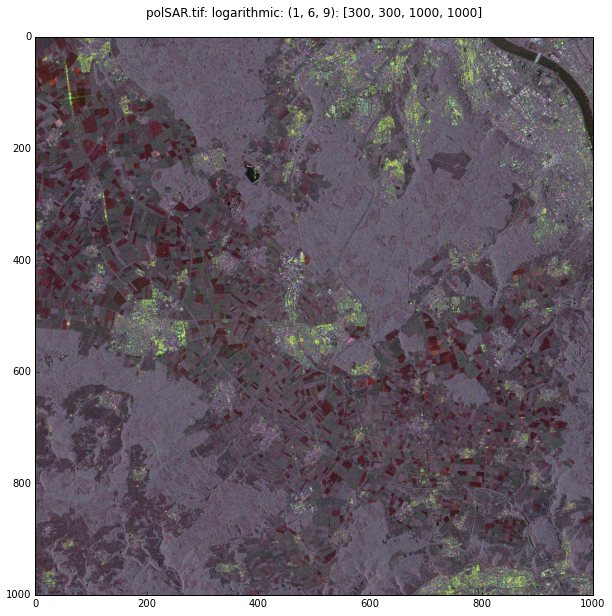

In [6]:
run /home/dispms -p [1,6,9] -d [300,300,1000,1000] -f /home/imagery/RS2_OK5491_PK71074_DK68879_FQ21_20100426_172459_HH_VV_HV_VH_SLC_MapReady/T3//polSAR.tif

The scene above was acquired over the city of Bonn, Germany (upper right hand corner with the Rhine river). The gray, featurless areas are mixed forest. 

To check the number of looks, We will run the __/home/enlml.py__ script (step 3 in the processing chain) on a spatial subset which includes a lot forested land cover. The spatial subset is entered with the -d flag as in the __/home/dispms__ script.

Here we choose -d [800,400,500,500]:

     ENL Estimation
Thu Dec 10 13:54:01 2015
infile:  /home/imagery/RS2_OK5491_PK71074_DK68879_FQ21_20100426_172459_HH_VV_HV_VH_SLC_MapReady/T3//polSAR.tif
Quad polarimetry
filtering...
row:  100  200  300  400 

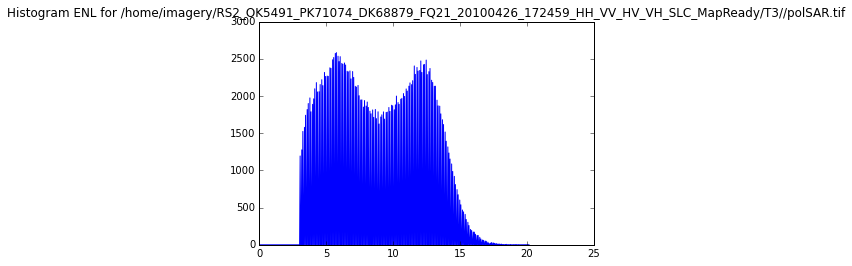

 ENL image written to: /home/imagery/RS2_OK5491_PK71074_DK68879_FQ21_20100426_172459_HH_VV_HV_VH_SLC_MapReady/T3/polSAR_enl.tif
elapsed time: 56.3928489685


In [8]:
run enlml -d [800,400,500,500] /home/imagery/RS2_OK5491_PK71074_DK68879_FQ21_20100426_172459_HH_VV_HV_VH_SLC_MapReady/T3//polSAR.tif

There are two modes (maxima) at about 6 and 12 looks. Here is the ENL image

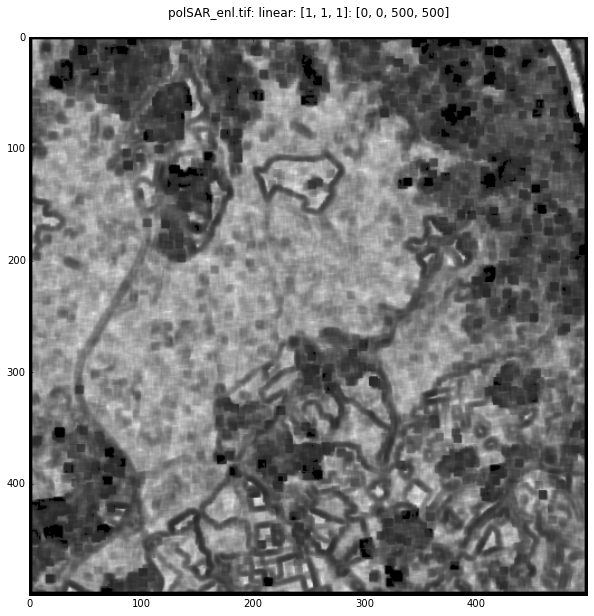

In [9]:
run dispms -e 2 -f /home/imagery/RS2_OK5491_PK71074_DK68879_FQ21_20100426_172459_HH_VV_HV_VH_SLC_MapReady/T3/polSAR_enl.tif

The bright areas correspond to mixed forest (around 12 equivalent looks) and allow for the best estimate of the ENL, see 
<a href="http://ieeexplore.ieee.org/xpl/login.jsp?tp=&arnumber=5071293&url=http%3A%2F%2Fieeexplore.ieee.org%2Fiel5%2F36%2F5291960%2F05071293.pdf%3Farnumber%3D5071293">Anfinsen et al. (2009)</a>. So we can conclude that the nominal and eqivalent number of looks are the same and equal to 12.

Next we geocode two more Radarsat-2 images, the ones acquired on May 20, 2010 (20100520) and June 7, 2010 (20100707):

In [11]:
!./mapready.sh 20100520 rs2quad

Geocoding polSARpro multilook polarimetric matrix image with mapready ...
dos2unix: converting file /home/imagery/RS2_OK5491_PK71074_DK68879_FQ21_20100520_172458_HH_VV_HV_VH_SLC/polsarpro/T3/config.txt to Unix format ...
Original SLC image dimensions:      rows 5538  cols 3788
After multi-looking with polSARpro: rows 1384  cols 1262
Azimuth looks: 4
Range looks:   3
***** processing polSARpro polarimetric matrix image:
***** /home/imagery/RS2_OK5491_PK71074_DK68879_FQ21_20100520_172458_HH_VV_HV_VH_SLC
***** ...
***** Done, see mapready.log
***** Combining into a single image file ...
     Ingest SAR
Thu Dec 10 14:03:28 2015
Directory /home/imagery/RS2_OK5491_PK71074_DK68879_FQ21_20100520_172458_HH_VV_HV_VH_SLC_MapReady/T3/
writing band 1
writing band 2
writing band 3
writing band 4
writing band 5
writing band 6
writing band 7
writing band 8
writing band 9
elapsed time: 1.36082291603
Multiband image is /home/imagery/RS2_OK5491_PK71074_DK68879_FQ21_20100520_172458_HH_VV_HV_VH_SLC_MapRead

In [12]:
!./mapready.sh 20100707 rs2quad

Geocoding polSARpro multilook polarimetric matrix image with mapready ...
dos2unix: converting file /home/imagery/RS2_OK5491_PK71074_DK68879_FQ21_20100707_172459_HH_VV_HV_VH_SLC/polsarpro/T3/config.txt to Unix format ...
Original SLC image dimensions:      rows 5537  cols 3788
After multi-looking with polSARpro: rows 1384  cols 1262
Azimuth looks: 4
Range looks:   3
***** processing polSARpro polarimetric matrix image:
***** /home/imagery/RS2_OK5491_PK71074_DK68879_FQ21_20100707_172459_HH_VV_HV_VH_SLC
***** ...
***** Done, see mapready.log
***** Combining into a single image file ...
     Ingest SAR
Thu Dec 10 14:06:20 2015
Directory /home/imagery/RS2_OK5491_PK71074_DK68879_FQ21_20100707_172459_HH_VV_HV_VH_SLC_MapReady/T3/
writing band 1
writing band 2
writing band 3
writing band 4
writing band 5
writing band 6
writing band 7
writing band 8
writing band 9
elapsed time: 1.37884497643
Multiband image is /home/imagery/RS2_OK5491_PK71074_DK68879_FQ21_20100707_172459_HH_VV_HV_VH_SLC_MapRead

Now let's perform the last processing step, polSAR change detection. The bitemporal bash script __/home/wishart.sh__ needs five input parameters, the two acquistion times in yyymmdd format, a spatial subset, and the two ENL values (which in principle can be different). We choose first of all the April and July images:

In [13]:
!./wishart.sh 20100426 20100707 [400,400,1000,1000] 12.0 12.0

***** Bitemporal PolSAR Change Detection
 
***** registering ...
     Register SAR
Thu Dec 10 14:06:53 2015
Reference image:
 /home/imagery/RS2_OK5491_PK71074_DK68879_FQ21_20100426_172459_HH_VV_HV_VH_SLC_MapReady/T3/polSAR.tif
Target image:
 /home/imagery/RS2_OK5491_PK71074_DK68879_FQ21_20100707_172459_HH_VV_HV_VH_SLC_MapReady/T3/polSAR.tif
warping 9 bands (quad pol)...
elapsed time: 13.5209531784
Warped image written to: /home/imagery/RS2_OK5491_PK71074_DK68879_FQ21_20100707_172459_HH_VV_HV_VH_SLC_MapReady/T3/polSAR_warp.tif
***** complex Wishart change detection ...
Bi-temporal Complex Wishart Change Detection
Thu Dec 10 14:07:07 2015
first filename:  /home/imagery/RS2_OK5491_PK71074_DK68879_FQ21_20100426_172459_HH_VV_HV_VH_SLC_MapReady/T3/polSAR.tif
number of looks: 12.000000
second filename:  /home/imagery/RS2_OK5491_PK71074_DK68879_FQ21_20100707_172459_HH_VV_HV_VH_SLC_MapReady/T3/polSAR_warp.tif
number of looks: 12.000000
Quad polarimetry
test statistic, change probabilities and c

Here is the 1% significance level change map image generated by the above script:

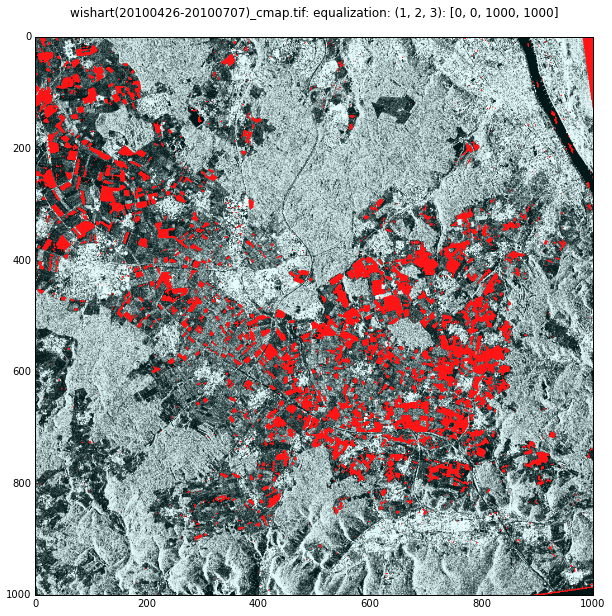

In [14]:
run dispms -e 4 -p [1,2,3] -f /home/imagery/RS2_OK5491_PK71074_DK68879_FQ21_20100426_172459_HH_VV_HV_VH_SLC_MapReady/T3/wishart(20100426-20100707)_cmap.tif

Over the interval late  April - early July separating the two acquisitions the significant changes are mostly in the agricultural areas near center right and upper left. Barge movements on the Rhine river are clearly evident. Zooming in on the upper left hand corner we can see a flooded  sand quarry pit with two dredging arms that are in continual motion, giving rise to significant change signals.

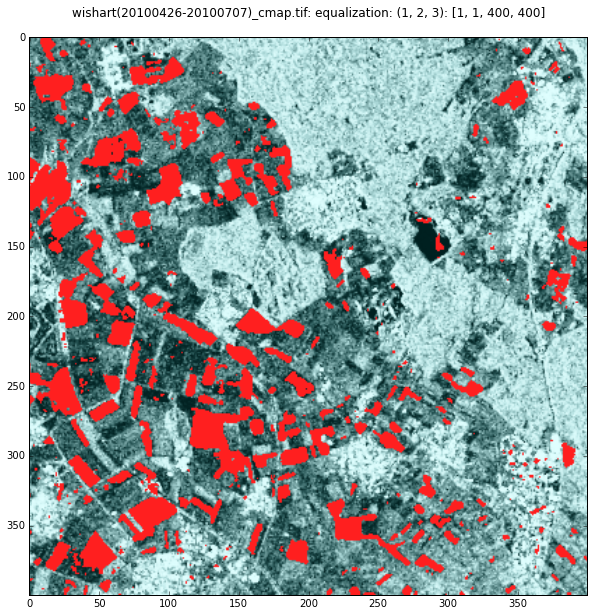

In [15]:
run dispms -e 4 -p [1,2,3] -d [1,1,400,400] -f /home/imagery/RS2_OK5491_PK71074_DK68879_FQ21_20100426_172459_HH_VV_HV_VH_SLC_MapReady/T3/wishart(20100426-20100707)_cmap.tif

Finally, we'll run the omnibus test statistic on all three images. The script requires the acquisition times, the spatial subset, the number of looks and the desired significance level:

In [16]:
!/home/omnibus.sh 20100426 20100520 20100707 [400,400,1000,1000] 12 0.01

***** Multitemporal PolSAR Change Detection **********
******************************************************
number of images  3
ENL               12
spatial subset    [400,400,1000,1000]
     Register SAR
Thu Dec 10 14:08:19 2015
Reference image:
 /home/imagery/RS2_OK5491_PK71074_DK68879_FQ21_20100426_172459_HH_VV_HV_VH_SLC_MapReady/T3/polSAR.tif
Target image:
 /home/imagery/RS2_OK5491_PK71074_DK68879_FQ21_20100520_172458_HH_VV_HV_VH_SLC_MapReady/T3/polSAR.tif
warping 9 bands (quad pol)...
elapsed time: 13.6758739948
Warped image written to: /home/imagery/RS2_OK5491_PK71074_DK68879_FQ21_20100520_172458_HH_VV_HV_VH_SLC_MapReady/T3/polSAR_warp.tif
     Register SAR
Thu Dec 10 14:08:33 2015
Reference image:
 /home/imagery/RS2_OK5491_PK71074_DK68879_FQ21_20100426_172459_HH_VV_HV_VH_SLC_MapReady/T3/polSAR.tif
Target image:
 /home/imagery/RS2_OK5491_PK71074_DK68879_FQ21_20100707_172459_HH_VV_HV_VH_SLC_MapReady/T3/polSAR.tif
warping 9 bands (quad pol)...
elapsed time: 13.5236520767
Warped i

We will display the bitemporal and multitemporal change maps side-by-side:

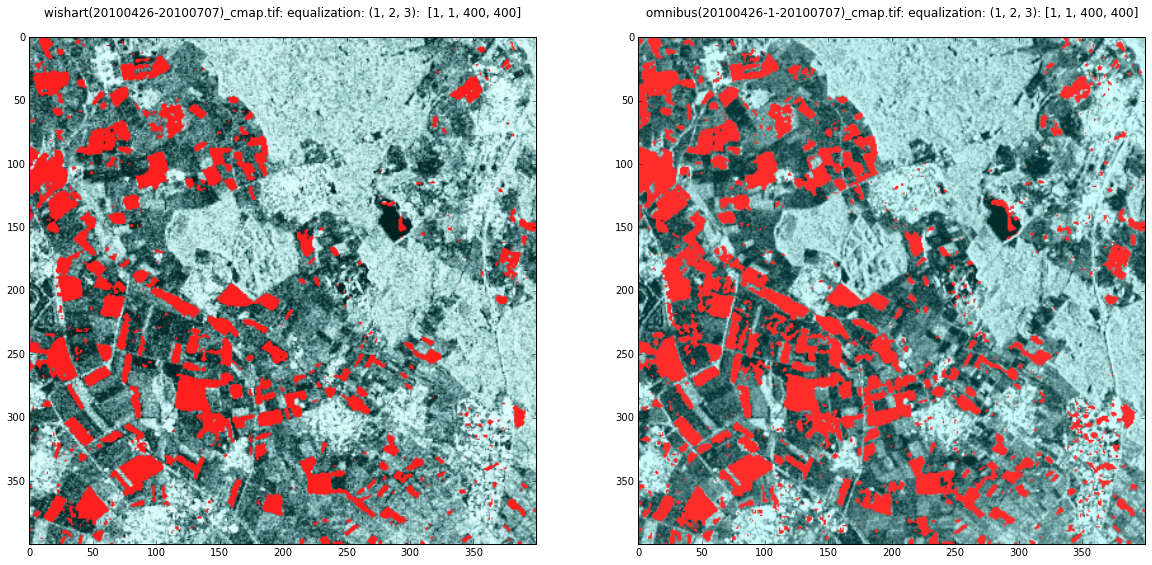

In [17]:
run /home/dispms -e 4 -p [1,2,3] -E 4 -P [1,2,3] -d [1,1,400,400] -D [1,1,400,400] -f /home/imagery/RS2_OK5491_PK71074_DK68879_FQ21_20100426_172459_HH_VV_HV_VH_SLC_MapReady/T3/wishart(20100426-20100707)_cmap.tif -F /home/imagery/RS2_OK5491_PK71074_DK68879_FQ21_20100426_172459_HH_VV_HV_VH_SLC_MapReady/T3/omnibus(20100426-1-20100707)_cmap.tif 

The multitemporal test (right hand image) detects more changes than the bitemporal test, at the same 1% significance level.

## Speckle Filtering (The gamma-MAP filter)

Let us represent an $m$ look-averaged SAR intensity image by the random variable $G$ 
with mean $\langle G\rangle=x$, where $x$ is  the underlying signal. Then  ${\rm var}(G) = x^2/m$
and $G$ is gamma-distributed with density function

$$
p(g\mid x) = {1\over (x/m)^m\Gamma(m)}g^{m-1}e^{-gm/x}.
$$

Let $G=xV$. Then it follows that $V$ has the density

$$
p(v) = {m^m\over\Gamma(m)}v^{m-1}e^{-vm}.
$$

Therefore, in terms of the observed pixel intensities $g$ (realizations of $G$), we can write

$$
g = x v,
$$

where v is distributed as above, and has mean 1 and variance $1/m$.

Because of this special _multiplicative noise_ nature of speckle, conventional smoothing filters  are not particularly suitable as an aid to SAR image interpretation.

The _gamma maximum a posteriori_ (gamma MAP) de-speckling filter
may be derived from Bayes' Theorem. The _a posteriori_
conditional probability for $x$, given intensity measurement $g$ is

$$
{\rm pr}(x\mid g) = { p(g\mid x){\rm pr}(x)\over p(g) },
$$

where $p(g\mid x)$ is given above, ${\rm pr}(x)$ is the prior probability for $x$
and $p(g)$ is the total probability density for $g$. This formulation allows us to include
prior knowledge of the signal statistics (or texture) if available. An empirical statistical model for $x$
is suggested by measurements of backscatter from ocean waves, namely

$$
{\rm pr}(x) \sim \left({\alpha\over\mu}\right)^\alpha {x^{\alpha-1}\over\Gamma(\alpha)}e^{-\alpha x/\mu}.
$$

This is just the gamma probability density with $\beta=\mu/\alpha$, and hence with mean $\alpha\beta= \mu$
and variance

$$
{\rm var}(x) = \alpha\beta^2 = \mu^2/\alpha.
$$

The parameters $\mu$ and $\alpha$ can be
estimated as follows. By passing an $n\times n$ window over the image we can obtain $\bar g = \langle g\rangle$ and ${\rm var}(g)$. Then
the estimates are

$$
\hat\mu = \bar g,
$$

and
$$
\hat\alpha = {\hat\mu^2\over {\rm var}(x)} = {\bar g^2\over {\rm var}(x)} ={1 + 1/m \over {{\rm var}(g)/\bar g^2 - 1/ m}}.
$$

Hence the posterior probability for $x$ given measurement $g$ is

$$
{\rm pr}(x\mid g) \sim {1\over (x/m)^m\Gamma(m)}g^{m-1}e^{-gm/x}\left({\alpha\over\mu}\right)^\alpha {x^{\alpha-1}\over\Gamma(\alpha)}e^{-\alpha x/\mu} =: L
$$

Taking the logarithm,

$$
\log L =\  m\log m -m\log x +(m-1)\log g - \log\Gamma(m)- mg/x
 +\alpha\log\alpha - \alpha\log\mu + (\alpha-1)\log x - \log\Gamma(\alpha) -\alpha x/\mu.
$$

We now get the maximum a posteriori (MAP) value for $x$ given the observed pixel intensity $g$ by maximizing $\log L$ with respect
to $x$:

$$
{d\over dx}\log L = -m/x + mg/ x^2 + (\alpha-1)/x - \alpha/\mu = 0.
$$

This leads to a quadratic equation for the most probable signal intensity $x$,

$$
{\alpha\over\mu}x^2 + (m+1-\alpha)x - mg = 0,
$$

where the parameters $\mu$ and $\alpha$ are estimated locally.
Note that in homogeneous regions where $m\approx \bar g^2/{\rm var}(g)$, $\hat\alpha\to\infty$. In that case $x\approx \hat\mu = \bar g$.

The gamma MAP filter is not appropriate to the complex off-diagonal matrix elements 
as their {\it a priori} statistics are not well understood.
The Python script __gamma_filter.py__ takes as input a polSAR image in covariance or coherency matrix form and
filters the diagonal elements only:

In [18]:
run gamma_filter -h


    Usage:
    ------------------------------------------------
    python gamma_filter.py [-h] [-p] [-d dims] filename enl
    
    Run a gamma MAP filter in the diagonal elements of a C or T matrix
     Set flag -p for parallel execution on (at least 2) IPython engines
    ------------------------------------------------


If the flag __-p__ is set, the filter will be run in parallel on the diagonal elements. This assumes that at least three IPython engines have been started, e.g., with the shell command

__ipcluster start -n 3__



In [19]:
run gamma_filter -d [300,300,200,200] /home/imagery/RS2_OK5491_PK71074_DK68879_FQ21_20100426_172459_HH_VV_HV_VH_SLC_MapReady/T3/polSAR.tif 12

    GAMMA MAP FILTER
Thu Dec 10 14:11:30 2015
infile:  /home/imagery/RS2_OK5491_PK71074_DK68879_FQ21_20100426_172459_HH_VV_HV_VH_SLC_MapReady/T3/polSAR.tif
equivalent number of looks: 12
filtering 3 diagonal matrix element bands ...
result written to: /home/imagery/RS2_OK5491_PK71074_DK68879_FQ21_20100426_172459_HH_VV_HV_VH_SLC_MapReady/T3/polSAR_gamma.tif
elapsed time: 59.1865420341


In [20]:
run gamma_filter -p -d [300,300,200,200] /home/imagery/RS2_OK5491_PK71074_DK68879_FQ21_20100426_172459_HH_VV_HV_VH_SLC_MapReady/T3//polSAR.tif 12

    GAMMA MAP FILTER
Thu Dec 10 14:17:12 2015
infile:  /home/imagery/RS2_OK5491_PK71074_DK68879_FQ21_20100426_172459_HH_VV_HV_VH_SLC_MapReady/T3//polSAR.tif
equivalent number of looks: 12
parallel processing requested
available engines: [0, 1, 2]
filtering 3 diagonal matrix element bands ...
result written to: /home/imagery/RS2_OK5491_PK71074_DK68879_FQ21_20100426_172459_HH_VV_HV_VH_SLC_MapReady/T3/polSAR_gamma.tif
elapsed time: 31.2239649296


We get a speedup of about a factor two. Here is the filtered image (left) compared to the original (right):

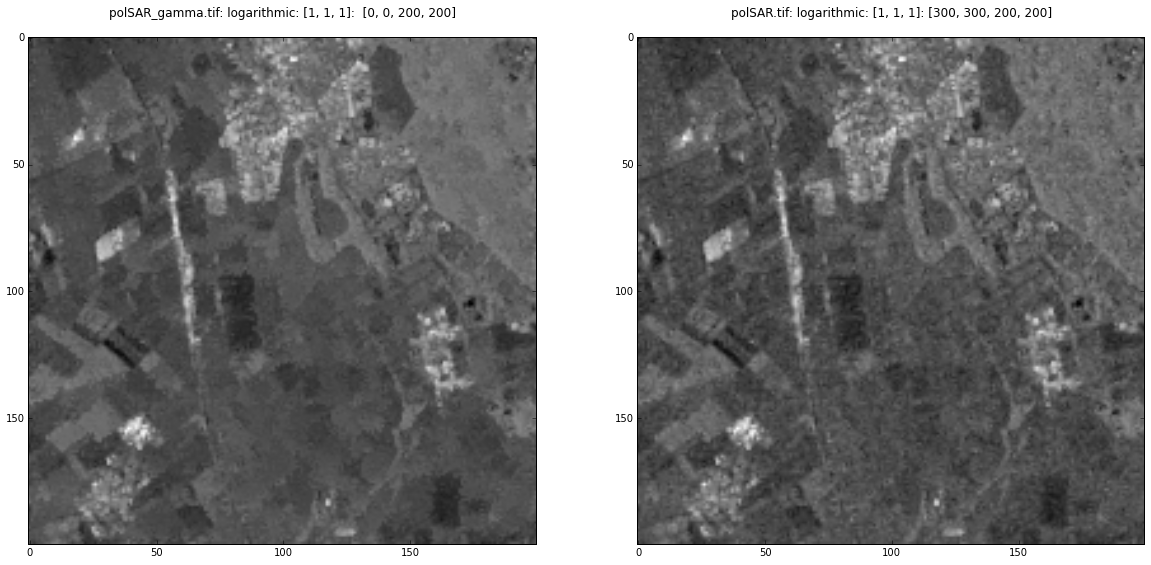

In [22]:
run /home/dispms -f /home/imagery/RS2_OK5491_PK71074_DK68879_FQ21_20100426_172459_HH_VV_HV_VH_SLC_MapReady/T3/polSAR_gamma.tif -F /home/imagery/RS2_OK5491_PK71074_DK68879_FQ21_20100426_172459_HH_VV_HV_VH_SLC_MapReady/T3/polSAR.tif -D [300,300,200,200]